# **METAMODELING WITH ARTIFICIAL NEURAL NETWORK**

In this notebook, we will use the results of Abaqus analyses in order to build an Artificial Neural Network (ANN) of the Finite Element (FE) analysis solver.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import sys
import os

In [2]:
# Scikit-learn
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

# Matplotlib spec
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

In [3]:
torch.__version__

'1.5.0'

When this notebook has been generated the result of the previous line of code is: _'1.5.0'_

We fix the seed in order to obtain reproducible results.

__N.B.__ : Reproducible results are obtained every time the runtime is restarded and runned. If you run multiple time the same cell the results will not be reporducible.

In [5]:
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)
random.seed(seed)

# Last two lines just when using GPU
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(seed=seed)

## **Data preprocessing**

We start by importing some information about the model used to generate the dataset.

In [28]:
# Check if notebook running in Colab
is_colab = 'google.colab' in sys.modules

# Model info folder
input_folder = './'

info = pd.read_csv(input_folder + 'model_info.csv', sep=";")
info.index = ['Value']
eff_plies = int(info['EffectivePlies'].values)
info.head()

,Height,Radius,MaxCurvature,MeshSize,Plies,EffectivePlies,Symmetric,Balanced,AnglesFunction,LoadCase,Train,Val,Test
Value,705,300,0.001575,5,8,2,True,True,harmlin,axial,81,27,27


In [29]:
sets = ['Train', 'Val', 'Test']
for set in sets:
    if set not in info.keys():
        sets.remove(set)

At this point we have to import the data set containing the input and output of the FE analysis. The data is stored in a dataframe in which the upper part is associated to the training set and the lower part to the test set. The precise number of upper row belonging to the train set is indicated in the info above.

In [30]:
# Data folder
data_folder = './'

data_orig = pd.read_csv(data_folder + '/data.csv', sep=';')
data = data_orig.drop(columns='Stiffness')
data_orig

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Buckling,Stiffness
0,65.08,20.60,0.39,38.52,14.60,76.85,1.27,13.29,235.051,281175.0
1,24.39,85.65,1.72,7.86,46.78,69.20,0.66,27.25,239.225,388831.0
2,19.29,45.21,1.29,8.63,87.30,76.00,0.53,2.56,190.754,465806.0
3,65.79,62.30,0.25,2.35,20.34,16.69,1.16,19.37,182.235,448824.0
4,13.92,28.67,0.07,26.28,57.23,84.57,0.48,20.18,248.555,365717.0
...,...,...,...,...,...,...,...,...,...,...
130,73.83,10.10,0.30,15.26,19.30,48.92,1.81,7.24,225.731,421545.0
131,33.20,6.00,1.23,36.61,94.59,58.90,0.23,26.93,225.708,194835.0
132,33.40,23.11,0.11,7.64,42.03,76.21,0.85,17.11,178.640,452326.0
133,23.20,25.50,0.49,32.97,84.96,32.20,0.18,9.29,243.416,322473.0


The most important step to perform before training our model is the normalization of the variables. Different strategies are possible at this end, among which 2 are the most used:

* Range normalization: converts all the values to the range $[0, 1]$

* Standard score normalization: forces the variables to have $0$ mean and $1$ standard deviation

We will try both to see the effect on the model performance.

In [267]:
def range_norm(x, x_min=None, x_max=None):
    """ Normalization in range [0, 1] """
    if x_min is None and x_max is None:
        x_min = np.min(x, axis=0)
        x_max = np.max(x, axis=0)
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm, x_min, x_max

def std_norm(x, m=None, s=None):
    """ Normalization with zero mean and unitary standard deviation """
    if m is None and s is None:
        m = np.mean(x, axis=0)
        s = np.std(x, axis=0)
    x_norm = (x - m) / s
    
    return x_norm, m, s

Now we can split the data into training and test set. The two sets have been generate independently during the DOE.

In [268]:
X = data_orig.drop(['Buckling', 'Stiffness'], axis=1).values
Y = data_orig[['Buckling','Stiffness']].values

# Train set
train_smp = int(info['Train'].values)
_X_train = X[:train_smp, :]
_Y_train = Y[:train_smp]
last = np.copy(train_smp)

# Validation set
if 'Val' in sets:
    val_smp = int(info['Val'].values)
    _X_val = X[last:last+val_smp, :]
    _Y_val = Y[last:last+val_smp]
    last += val_smp

# Test set
if 'Test' in sets:
    test_smp = int(info['Test'].values)
    _X_test = X[last:last+test_smp, :]
    _Y_test = Y[last:last+test_smp]

print('             - - - - - - - ')
print('            |Problem info:|')
print('             - - - - - - -  \n')
print("X_train : {}  |  Y_train : {}".format(_X_train.shape, _Y_train.shape))
print("X_val   : {}  |  Y_val   : {}".format(_X_val.shape, _Y_val.shape))
print("X_test  : {}  |  Y_test  : {} \n".format(_X_test.shape, _Y_test.shape))

             - - - - - - - 
            |Problem info:|
             - - - - - - -  

X_train : (81, 8)  |  Y_train : (81, 2)
X_val   : (27, 8)  |  Y_val   : (27, 2)
X_test  : (27, 8)  |  Y_test  : (27, 2) 



At this point we can generate the iterable data sets for Torch

In [269]:
def shuffle_data(X, Y):
    """ Random shuffle of samples in X and y """
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    return X[idx], Y[idx]

In [270]:
# Normalization training set
X_train, x_min, x_max = range_norm(_X_train)
Y_train, y_min, y_max = range_norm(_Y_train)

# Shuffle training set
X_train, Y_train = shuffle_data(X_train, Y_train)

In [271]:
# Normalization validation set
X_val, _, _ = range_norm(_X_val, x_min=x_min, x_max=x_max)
Y_val, _, _ = range_norm(_Y_val, x_min=y_min, x_max=y_max)

# Normalization testing set
X_test, _, _ = range_norm(_X_test, x_min=x_min, x_max=x_max)
Y_test, _, _ = range_norm(_Y_test, x_min=y_min, x_max=y_max)

In [273]:
def create_batches(_X, _Y, batch_size):
    """ Split the data into k batches """

    n_samples = _X.shape[0]
    leftovers = {}
    n_leftovers = n_samples % batch_size
    
    # Case with all batches of equal size
    if n_leftovers != 0:
        leftovers["X"] = _X[-n_leftovers:]
        leftovers["Y"] = _Y[-n_leftovers:]
        _X = _X[:-n_leftovers]
        _Y = _Y[:-n_leftovers]

    k = np.int(_X.shape[0] / batch_size)
        
    X_split = np.split(_X, k)
    Y_split = np.split(_Y, k)
    
    # Add leftover samples as last batch
    if n_leftovers != 0:
        X_split.append(leftovers["X"])
        Y_split.append(leftovers["Y"])

    return X_split, Y_split

In [274]:
batch_size = 16
X_train_b, Y_train_b = create_batches(X_train, Y_train, batch_size=batch_size)

In [275]:
print("Batches dimensions: \n")
for i in range(len(X_train_b)):
    print("Batch {} : input {}  ,  output : {}".format(i, X_train_b[i].shape, Y_train_b[i].shape))

Batches dimensions: 

Batch 0 : input (16, 8)  ,  output : (16, 2)
Batch 1 : input (16, 8)  ,  output : (16, 2)
Batch 2 : input (16, 8)  ,  output : (16, 2)
Batch 3 : input (16, 8)  ,  output : (16, 2)
Batch 4 : input (16, 8)  ,  output : (16, 2)
Batch 5 : input (1, 8)  ,  output : (1, 2)


## **Neural network**

First define network class

In [276]:
class FFNN(torch.nn.Module):

    def __init__(self, D_in, H, D_out):
        super(FFNN, self).__init__()
        # First hidden layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(H, D_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Second hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Third hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Output layer
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(D_out, H)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(D_out), 0))
        
        # define activation function in constructor
        self.activation_1 = torch.nn.ReLU()
        self.activation_2 = torch.nn.ReLU()
        self.activation_3 = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation_1(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation_2(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation_3(x)
        pred = F.linear(x, self.W_4, self.b_4)
        return pred

In [ ]:
n_x = X_train.shape[1]
n_y = Y_train.shape[1]
D_in, H, D_out = n_x, 8, n_y

model = FFNN(D_in, H, D_out)

epochs = 50000
lr = 1e-3
weight_decay = 5e-3

# Flag True if you are in the network optimization process.
is_optimizing = True

# If weight_NN exists and we are not in optimization mode just load
# network weights and evaluate the model.
if(os.path.isfile('net_weights/weights_NN') and is_optimizing==False):
    model.load_state_dict(torch.load('net_weights/weights_NN'))
    print(model.eval())
else:
    criterion = nn.MSELoss(reduction='mean') 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Initialize losses lists.
    train_loss = []
    val_loss = []
    losses = []
    
    idx = np.arange(len(X_train_b))
    
    for epoch in range(epochs):
        curr_loss = 0
        np.random.shuffle(idx)
        
        model.train()
        for batch_num in idx:
            
            # Create torch variables, required dtype 'float32' no 'float64'
            batch_x = Variable(torch.from_numpy(X_train_b[batch_num].astype('float32')))
            batch_y = Variable(torch.from_numpy(Y_train_b[batch_num].astype('float32')))
            optimizer.zero_grad()
            
            y_pred = model(batch_x)
            
            batch_loss = criterion(y_pred, batch_y)
            batch_loss.backward()
            optimizer.step()
            
            curr_loss += batch_loss
            
        train_loss.append(curr_loss.item() / len(idx))
        
        model.eval()
        val_x = Variable(torch.from_numpy(X_val.astype('float32')))
        val_y = Variable(torch.from_numpy(Y_val.astype('float32')))
        val_pred = model(val_x)
        loss_val = criterion(val_pred, val_y)
            
        val_loss.append(loss_val.item())

        if epoch % 1000 == 0:
            print("Iteration : {} | Train loss : {:.5f} | Val loss : {:.5f}".format(epoch, train_loss[epoch], val_loss[epoch]))

    torch.save(model.state_dict(), 'weights_NN')

In [288]:
model.eval()
val_x = Variable(torch.from_numpy(X_val.astype('float32')))
val_y = Variable(torch.from_numpy(Y_val.astype('float32')))

val_pred = model(val_x)
for i in range(val_y.shape[0]):
    err_perc = abs(val_y.numpy() - val_pred.detach().numpy()) / val_y.numpy() * 100
    print("True : {:.4f}, {:.4f}  |  Prediction : {:.4f}, {:.4f}  |  Error : {:07.2f}%, {:07.2f}%".
          format(*val_y[i, :].numpy(), *val_pred[i, :].detach().numpy(), *err_perc[i, :]))

True : 0.3638, 0.8316  |  Prediction : 0.4681, 0.7057  |  Error : 0028.68%, 0015.14%
True : 0.3959, 0.5257  |  Prediction : 0.5849, 0.5232  |  Error : 0047.76%, 0000.46%
True : 0.7227, 0.6914  |  Prediction : 0.4974, 0.7035  |  Error : 0031.18%, 0001.74%
True : 0.8112, 0.5329  |  Prediction : 0.6547, 0.6297  |  Error : 0019.29%, 0018.16%
True : 0.5953, 0.5242  |  Prediction : 0.5351, 0.5657  |  Error : 0010.11%, 0007.92%
True : 0.7859, 0.2206  |  Prediction : 0.5705, 0.2897  |  Error : 0027.40%, 0031.31%
True : 0.0819, 0.9479  |  Prediction : 0.1012, 0.8987  |  Error : 0023.57%, 0005.19%
True : 0.4528, 0.2445  |  Prediction : 0.6051, 0.3657  |  Error : 0033.63%, 0049.58%
True : 0.1739, 0.4272  |  Prediction : 0.4725, 0.4238  |  Error : 0171.66%, 0000.79%
True : 0.6732, 0.5245  |  Prediction : 0.5500, 0.5843  |  Error : 0018.31%, 0011.40%
True : 0.9800, 0.4190  |  Prediction : 0.8272, 0.4387  |  Error : 0015.59%, 0004.69%
True : 0.5051, 0.1334  |  Prediction : 0.5625, 0.1115  |  Error :

(-0.0, 0.05)

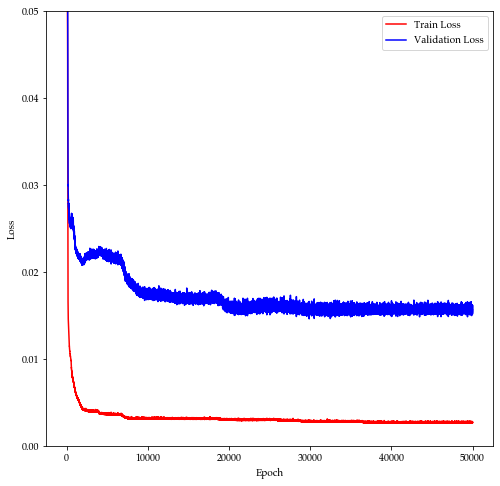

In [290]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), train_loss, 'r', np.arange(epochs), val_loss, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.ylim(-.0, .05)

In [239]:
model.eval()
test_x = Variable(torch.from_numpy(X_test.astype('float32')))
test_y = Variable(torch.from_numpy(Y_test.astype('float32')))

test_pred = model(test_x)
for i in range(test_y.shape[0]):
    err_perc = (test_y.numpy() - test_pred.detach().numpy()) / test_y.numpy() * 100
    print("True : {:.4f}, {:.4f}  |  Prediction : {:.4f}, {:.4f}  |  Error : {:07.2f}%, {:07.2f}%".
          format(*test_y[i, :].numpy(), *test_pred[i, :].detach().numpy(), *err_perc[i, :]))

True : 0.0000, 1.0000  |  Prediction : 0.1421, 0.9492  |  Error : -000inf%, 0005.08%
True : 0.3511, 0.9285  |  Prediction : 0.2318, 0.8341  |  Error : 0033.98%, 0010.17%
True : 1.0000, 0.2829  |  Prediction : 0.6488, 0.3021  |  Error : 0035.12%, -006.78%
True : 0.7298, 0.7303  |  Prediction : 0.5278, 0.7440  |  Error : 0027.68%, -001.87%
True : 0.4944, 0.0000  |  Prediction : 0.3526, 0.0986  |  Error : 0028.68%, -000inf%
True : 0.7922, 0.3160  |  Prediction : 0.6637, 0.4046  |  Error : 0016.22%, -028.04%
True : 0.5921, 0.1089  |  Prediction : 0.6719, 0.1797  |  Error : -013.47%, -065.05%
True : 0.4387, 0.7176  |  Prediction : 0.3152, 0.8021  |  Error : 0028.14%, -011.77%
True : 0.8501, 0.2274  |  Prediction : 0.6345, 0.1888  |  Error : 0025.36%, 0016.97%
True : 0.7577, 0.1817  |  Prediction : 0.5090, 0.2294  |  Error : 0032.83%, -026.25%
True : 0.1602, 0.8757  |  Prediction : 0.6438, 0.6759  |  Error : -301.91%, 0022.82%
True : 0.5556, 0.1890  |  Prediction : 0.4549, 0.3026  |  Error :

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [ ]:
class EarlyStopping:
    def __init__(self, patience=30, delta=1e-3, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        if self.val_loss_min > val_loss:
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True